## Description

This programming homework has two parts. In the first part, you will build, train and test a MLP network for a 2D synthetic dataset. In the second part, you will develop an encoder-decoder  CNN architecture for image reconstruction and use the encoder part for further training a classifier. You will be using the MNIST dataset.

The first part is 30 points, the second part is 70 points.

# PART 1 [30 pts]
In this part, you will build, train and test a MLP. Your MLP should give a reasonable accuracy (better than chance level) on the test set.

Follow the instructions below.

**The parts that you are expected to code are marked with "YOUR CODE HERE". You are not allowed to change other parts of the code.**

In [35]:
# Let's first import required modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification


In [36]:
# we will use the Moons and Circles datasets from Scikit-learn.

# Let's create two datasets
moons = make_circles(1000, random_state=0,factor=0.5, noise=0.1)
circles = make_moons(1000, random_state=0, noise=0.1)


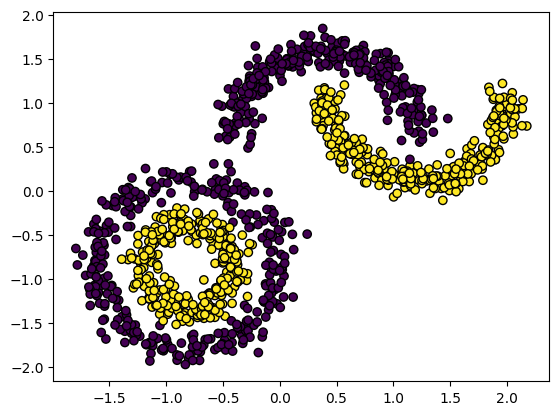

In [37]:
# Here, we will combine these two datasets to make it a more challenging problem.
X, y = moons
X1,y1 = circles
X = np.vstack((X,X1+1.5))
y = np.hstack((y,y1))

# pre-proces data
X = StandardScaler().fit_transform(X)

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
    )

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# Plot the training points
ax = plt.axes()
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,  edgecolors="k")

## Task 1

Define  a multilayer perceptron network class using PyTorch. Its class name should be "MLP".

Create an instance from this class; its name should be "mlp".

In [38]:
# YOUR CODE HERE
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# define the model class
class MLP(nn.Module):
  def __init__(self, input_size, num_hidden_neurons, num_classes):
    super(MLP,self).__init__()
    self.fc_layer_1 = nn.Linear(input_size, num_hidden_neurons)
    self.fc_layer_2 = nn.Linear(num_hidden_neurons, num_classes)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self,input):
    x = self.relu(self.fc_layer_1(input))
    x = self.sigmoid(self.fc_layer_2(x))
    return x

# create an instance of the class
# input x , y coordinates, output 1, two different class it will show the probability of one class
# and the other is complementary
mlp = MLP(input_size = 2, num_hidden_neurons= 64, num_classes=1)



## Task 2

Define the loss function and the optimizer. Use binary cross-entropy loss. The choice of the optimizer is up to you.

In [39]:
# YOUR CODE HERE
# loss function
loss_function = nn.BCELoss()

# lets define a learning rate
learning_rate = 0.05
optimizer = torch.optim.Adam(mlp.parameters(), learning_rate)


## Task 3

Create train dataloader and test dataloader from the dataset splits that we created above. The dataloaders should be instances of the "DataLoader" class in PyTorch. (Hint: there is an example at https://www.kaggle.com/code/glebbuzin/solving-sklearn-datasets-with-pytorch)

In [40]:
# YOUR CODE HERE
# first convert to tensors
X_train_tensor = torch.from_numpy(X_train).to(torch.float32)
y_train_tensor = torch.from_numpy(y_train).to(torch.float32)
X_test_tensor = torch.from_numpy(X_test).to(torch.float32)
y_test_tensor = torch.from_numpy(y_test).to(torch.float32)

# then create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=128)


## Task 4

Train your "mlp". This code should also plot the training loss versus iterations (or epochs -- up to you).

In [41]:
# YOUR CODE HERE
num_epochs = 50

for epoch in range(num_epochs):
  for inputs, ground_truths in train_dataloader:
        # clear the previous gradient calculations
        optimizer.zero_grad()

        # Forward pass
        outputs = mlp(inputs)
        total_loss = loss_function(outputs.squeeze(),ground_truths)

        # Backward pass
        total_loss.backward()

        # Update the model's parameters
        optimizer.step()


The following code runs your "mlp" on a meshgrid of points and plots the result on this grid. It visualizes the decision boundary (and regions) for your "mlp".

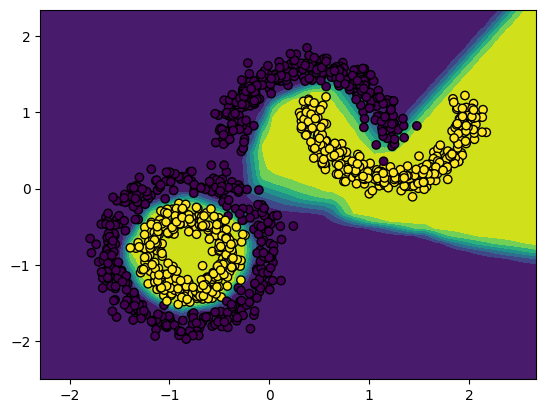

In [43]:
xs, ys = np.meshgrid(np.linspace(x_min, x_max), np.linspace(y_min, y_max))
gr_data = np.float32(np.vstack((xs.flatten(), ys.flatten())).transpose())
gr_out = mlp(torch.from_numpy(gr_data))
gr_out = gr_out.detach().numpy().reshape(xs.shape)

ax = plt.axes()
ax.contourf(xs,ys,gr_out, )
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,  edgecolors="k")

## Task 5

Evaluate your trained "mlp" on the test set. This piece of code should print out the percentage of correctly predicted test points. This is your test accuracy.

In [44]:
# YOUR CODE HERE

# switch to evaluation mode , this will disable dropout layers and certain batch normalization statistics
mlp.eval()

# to save memory and computation do not calculate gradients
with torch.no_grad():
  num_correct_samples = 0
  num_all_samples = 0
  for test_inputs, test_ground_truths in test_dataloader:

        # calculate the output
        outputs = mlp(test_inputs)
        predictions = ((outputs > 0.5).int()).squeeze()

        num_correct_samples += (predictions == test_ground_truths).sum().item()
        num_all_samples += test_ground_truths.size(0) #number of rows

  test_accuracy = (num_correct_samples/num_all_samples)*100

print(f"Test accuracy: {test_accuracy}")

Test accuracy: 98.625


## Task 6 (final task)

Now do a grid search on the learning rate to improve your test accuracy. Try at least three different learning rates. The search should be done on a validation set that is separate from the test set. You can spare 20% of the training set to obtain your validation set.  

In [45]:
# YOUR CODE HERE

# DATA PREPARATION
# we could do the creation of the validation data set from scratch by splitting X_train randomly. However
# spliting the train data tensor randomly will also serve the same purpose

# Split the training set into training and validation sets
validation_data_size = int(0.2 * len(train_dataset))  # 20% for validation
train_data_size = len(train_dataset) - validation_data_size
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_data_size, validation_data_size])

# Create the dataloaders for training and validation. We already created for testing, shuffle is true by default
train_dataloader = DataLoader(train_dataset, batch_size=128)
validation_dataloader = DataLoader(validation_dataset, batch_size=128)


# lets define possible learning rates
learning_rates = {0.1, 0.05, 0.01}
num_of_epochs = 50

for learning_rate in learning_rates:
  mlp = MLP(2,64,1)
  optimizer = torch.optim.Adam(mlp.parameters(), learning_rate)

  ## TRAIN PART
  for epoch in range(num_of_epochs):
      for inputs, ground_truths in train_dataloader:
        # clear the previous gradient calculations
        optimizer.zero_grad()

        # Forward pass
        outputs = mlp(inputs)
        total_loss = loss_function(outputs.squeeze(),ground_truths)

        # Backward pass
        total_loss.backward()

        # Update the model's parameters
        optimizer.step()
  final_training_loss = total_loss

  ## VALIDATION PART
  with torch.no_grad():
    num_correct_samples = 0
    num_all_samples = 0
    for val_inputs, val_ground_truths in validation_dataloader:

        # calculate the output
        outputs = mlp(val_inputs)
        predictions = ((outputs > 0.5).int()).squeeze()

        num_correct_samples += (predictions == val_ground_truths).sum().item()
        num_all_samples += val_ground_truths.size(0) #number of rows

  validation_set_accuracy = (num_correct_samples/num_all_samples)*100

  ## TESTING PART
  with torch.no_grad():
    num_correct_samples = 0
    num_all_samples = 0
    for test_inputs, test_ground_truths in test_dataloader:

        # calculate the output
        outputs = mlp(test_inputs)
        predictions = ((outputs > 0.5).int()).squeeze()

        num_correct_samples += (predictions == test_ground_truths).sum().item()
        num_all_samples += test_ground_truths.size(0) #number of rows

  test_set_accuracy = (num_correct_samples/num_all_samples)*100

  print(f"Learning rate (lr): {learning_rate}, Final training loss: {final_training_loss},	Validation set accuracy: {validation_set_accuracy}, Test set accuracy: {test_set_accuracy}")




Learning rate (lr): 0.1, Final training loss: 0.017521636560559273,	Validation set accuracy: 96.66666666666667, Test set accuracy: 98.625
Learning rate (lr): 0.01, Final training loss: 0.07065214961767197,	Validation set accuracy: 98.33333333333333, Test set accuracy: 99.5
Learning rate (lr): 0.05, Final training loss: 0.01780916564166546,	Validation set accuracy: 98.33333333333333, Test set accuracy: 99.375


Report your results by completing the table below.

| Learning rate (lr) | Final training loss | Validation set accuracy | Test set accuracy |
| ---                | ---                 | ---               | ---
| lr1= 0.1 |0.0175  |96.66  | 98.625 |
| lr2= 0.01 |0.0706  |98.33  | 99.5 |
| lr3= 0.05 |0.0178  |98.33  | 99.375 |



# PART 2 [70 pts]
In this part, you will work on developing an encoder-decoder (see figure below) CNN architecture for image reconstruction and use the encoder part for further training a classifier. You will be using the MNIST dataset.

**The parts that you are expected to code are marked with "YOUR CODE HERE". You are not allowed to change other parts of the code.**

You will design an encoder CNN which maps a given MNIST image (28x28 image) to a HxWxC dimensional image. Here $H\cdot W\cdot C$ should be less than 64. Then, you will also design a decoder CNN which will take this HxWxC image and output a 28x28 image.

Note that in this  description, batch size is 1 for ease of illustration. Batch size is not 1 in the tasks below.  


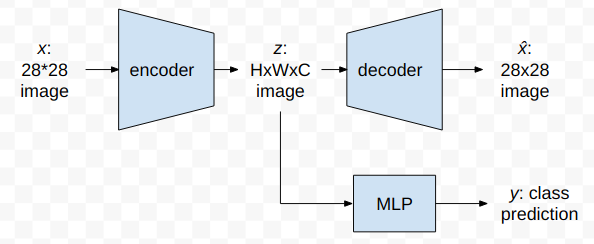

Next, you will design a classifier MLP that takes the HxWxC dimensional encoder output and predicts its category.

These three networks will be trained in different ways as explained in the tasks below.

In [46]:
# Import the required modules
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [47]:
# Define the "device". If GPU is available, device is set to use it, otherwise CPU will be used.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Make sure you select "GPU" or "TPU" as the Hardware Accelarator, which is accesible from the "Rutime -> Change runtime type" menu.

In [48]:
# Download the dataset
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 64550238.47it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 75146212.05it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 20259164.95it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16035798.63it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [49]:
# About the ToTensor() transformation.

# PyTorch networks expect a tensor as input with dimensions N*C*H*W  where
# N: batch size
# C: channel size
# H: height
# W: width

# Normally an image is of size H*W*C.
# ToTensor() transformation moves the channel dimension to the beginning as needed by PyTorch.

In [50]:
# Define the data loaders
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset =  test_data ,
                                      batch_size = batch_size,
                                      shuffle = False)

## Task 1

Define the Encoder CNN. It will accept a Nx1x28x28 input tensor (where N is the batch size) and output a NxCxHxW tensor. $H\cdot W \cdot C$ should be less than 64, e.g. H=4, W=4 and C=3. You can use conv2d, relu and pooling layers as necessary.

In [51]:
# Define the encoder CNN

class Encoder(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Encoder, self).__init__()
        # YOUR CODE HERE
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding = 0) ## 26X26
        self.batch_norm_1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding = 0) ## 24x24
        self.batch_norm_2 = nn.BatchNorm2d(8)
        self.relu2 = nn.ReLU()

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 12x12

        self.conv3 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=1, padding = 0) ## 10x10
        self.batch_norm_3 = nn.BatchNorm2d(4)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=4, out_channels=3, kernel_size=3, stride=1, padding = 0) ## 8x8
        self.batch_norm_4 = nn.BatchNorm2d(3)
        self.relu4 = nn.ReLU()

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 4x4

    def forward(self, x):
        # YOUR CODE HERE

        x = self.relu1( self.batch_norm_1(self.conv1(x)))
        x = self.relu2(self.batch_norm_2(self.conv2(x)))
        x = self.pool1(x)
        x = self.relu3( self.batch_norm_3(self.conv3(x)))
        x = self.relu4(self.batch_norm_4(self.conv4(x)))
        x = self.pool2(x)
        return x


Let's create an instance of Encoder and run it on a random input tensor to see if it outputs the expected dimensions.

In [52]:
# Create an instance
encoder = Encoder().to(device)

x = torch.randn(20, 1, 28, 28).to(device)
y = encoder(x)
print(x.shape)
print(y.shape)  # this should print "torch.Size([20, 3, 4, 4])"

torch.Size([20, 1, 28, 28])
torch.Size([20, 3, 4, 4])


## Task 2
Define the Decoder CNN. It will accept NxCxHxW dimensional input tensor and will output Nx1x28x28 dimensional tensor.  Use "deconvolution" layers, which are implemented by the `ConvTranspose2d` function in PyTorch. You might need to set `stride` and `output_padding` values to adjust dimensions.

In [53]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    # YOUR CODE HERE
    # calculate z = s -1 , p' = k - p -1 --> insert z zeros between rows and columns , add p' number of zeros around the image --> slide with stride = 1
    # out = (inp - 1).s -2p + k + op
    # input 3x4x4
    self.deconv_1 = nn.ConvTranspose2d(in_channels=3, out_channels=4, kernel_size=3, stride=2, padding=0, output_padding=1) # (4 - 1).2 -2*0 + 3 + 1 = 6  + 4 = 10
    self.batch_norm_1 = nn.BatchNorm2d(4)
    self.relu1 = nn.ReLU()

    self.deconv_2 = nn.ConvTranspose2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=0, output_padding= 0) # (10 - 1).1 -2*0 + 3 + 0 = 9  + 3= 12
    self.batch_norm_2 = nn.BatchNorm2d(8)
    self.relu2 = nn.ReLU()

    self.deconv_3 = nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=0, output_padding=1) # (12 - 1).2 -2*0 + 3 + 1 = 22 + 4 = 26
    self.batch_norm_3 = nn.BatchNorm2d(16)
    self.relu3 = nn.ReLU()

    self.deconv_4 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=0, output_padding=0)  # (26 - 1).1 -2*1 + 0 + 0 = 25 + 3  = 28
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # YOUR CODE HERE

    x = self.relu1(self.batch_norm_1(self.deconv_1(x)))
    x = self.relu2(self.batch_norm_2(self.deconv_2(x)))
    x = self.relu3(self.batch_norm_3(self.deconv_3(x)))
    x = self.deconv_4(x)
    x = self.sigmoid(x)
    return x

Let's create an instance of Decoder and run it on a random input tensor to see if it outputs the expected dimensions.

In [54]:
# Create an instance
decoder = Decoder().to(device)

x = torch.randn(20, 3, 4, 4).to(device)
y = decoder(x)
print(x.shape)
print(y.shape) # this should print "torch.Size([20, 1, 28, 28])"

torch.Size([20, 3, 4, 4])
torch.Size([20, 1, 28, 28])


## Task 3

Train the encoder and decocer simultaneously to minimize the mean squared error (MSE), that is

$$L = \frac{1}{M}\sum_{i=1} (x_i - \hat{x}_i)^2 $$

where $M$ is the number of all examples in the training set.

In [56]:
# Define the loss function and the optimizer
loss_fun = nn.MSELoss() # YOUR CODE HERE
params = list(encoder.parameters()) + list(decoder.parameters()) # YOUR CODE HERE
optimizer = torch.optim.Adam( params, lr=1.e-3)

In [57]:

# Train the model

num_epochs = 5
loss_history = []
for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_loader):
    images = images.to(device)

    optimizer.zero_grad()
    latent = encoder(images)
    rec = decoder(latent)
    loss = loss_fun(rec, images)
    loss.backward()
    optimizer.step()

    if (i+1) % batch_size == 0:
      loss_history.append(loss.item())
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.0487
Epoch [1/5], Step [200/600], Loss: 0.0292
Epoch [1/5], Step [300/600], Loss: 0.0254
Epoch [1/5], Step [400/600], Loss: 0.0213
Epoch [1/5], Step [500/600], Loss: 0.0203
Epoch [1/5], Step [600/600], Loss: 0.0192
Epoch [2/5], Step [100/600], Loss: 0.0175
Epoch [2/5], Step [200/600], Loss: 0.0176
Epoch [2/5], Step [300/600], Loss: 0.0167
Epoch [2/5], Step [400/600], Loss: 0.0165
Epoch [2/5], Step [500/600], Loss: 0.0160
Epoch [2/5], Step [600/600], Loss: 0.0164
Epoch [3/5], Step [100/600], Loss: 0.0151
Epoch [3/5], Step [200/600], Loss: 0.0150
Epoch [3/5], Step [300/600], Loss: 0.0143
Epoch [3/5], Step [400/600], Loss: 0.0146
Epoch [3/5], Step [500/600], Loss: 0.0145
Epoch [3/5], Step [600/600], Loss: 0.0148
Epoch [4/5], Step [100/600], Loss: 0.0136
Epoch [4/5], Step [200/600], Loss: 0.0150
Epoch [4/5], Step [300/600], Loss: 0.0150
Epoch [4/5], Step [400/600], Loss: 0.0137
Epoch [4/5], Step [500/600], Loss: 0.0133
Epoch [4/5], Step [600/600], Loss:

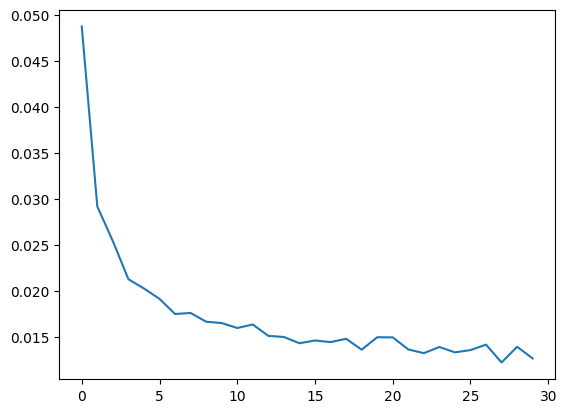

In [58]:
import matplotlib.pyplot as plt
plt.plot(loss_history)

Show an example $x$ and its correspoinding $\hat{x}$.

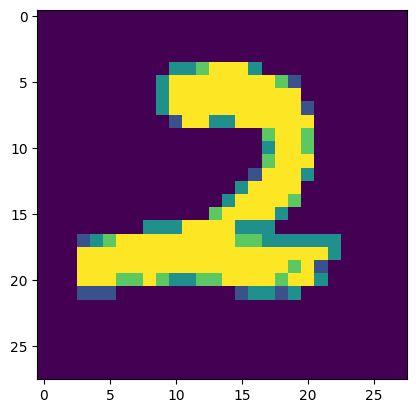

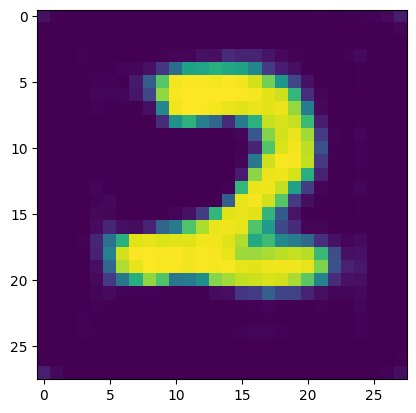

In [59]:
plt.imshow(images[0,0,].cpu().numpy())
plt.show()
plt.imshow(rec[0,0,].detach().cpu().numpy())
plt.show()

how I designed my model, primarily by trying things out and logical intuitions.

I prefer using a simple model, even if adding more channels might make it more accurate. But that accuracy boost might be the model memorizing things. Since the task is straightforward, I stick with a simple model.

At first, I used a 3-layered encoder and decoder, and it worked well. But to get the same success with the current model, I had to increase the epoch number to at least 10. Since I couldn't change the epoch number, I decided to use a 4-layered encoder-decoder model because I was allowed to train it with five epochs.

I noticed that when the encoder and decoder structures match, accuracy improves. By matching, I mean having the same number of layers, the output size, and the channel numbers in a mirrored way, just like the figure of an encoder and decoder structure in the lecture slides.

It's essential not to use batch normalization at the output layer. If you do, it messes with the structure and can blur things.

It's generally better to increase or keep kernel sizes the same for improved accuracy. In my image reconstruction model, a size of 3 worked better than 5.

When pooling, it's better to use a stride of 2. Using a stride of 1 messed with the accuracy of the output layer without giving us more helpful information about the picture, unlike a stride of 2. I guess it was like taking the averages, which might deform the shape of the output image

These are just some things I noticed and considered while figuring out how to improve my model.

## Task 4

Define the classifier MLP and train on encoder outputs. It should accept NxCxHxW tensor and output Nx10 tensor. Note that 10 is the number of classes in MNIST.

Hint: it should first flatten the CxHxW part.

Regarding the architecture of the MLP: just one hidden layer is sufficient but more layers are fine. The design is up to you.

In this task, **only the MLP part should be trained**.

In [60]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        # 3x4x4 = 48
        self.fc_layer_1 = nn.Linear(48, 64)
        self.relu = nn.ReLU()
        # 10 classes
        self.fc_layer_2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc_layer_1(x))
        return self.fc_layer_2(x)

# Create an instance
mlp = MLP().to(device)

print(mlp)
x = torch.randn(20, 3, 4, 4).to(device)
y = mlp(x)
y.shape

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layer_1): Linear(in_features=48, out_features=64, bias=True)
  (relu): ReLU()
  (fc_layer_2): Linear(in_features=64, out_features=10, bias=True)
)


torch.Size([20, 10])

In [61]:
# Define the loss function and the optimizer
loss_fun = nn.CrossEntropyLoss() # YOUR CODE HERE
params = list(mlp.parameters()) # YOUR CODE HERE
optimizer = torch.optim.Adam(params, lr=1.e-3)

Epoch [1/2], Step [100/600], Loss: 0.9980
Epoch [1/2], Step [200/600], Loss: 0.5699
Epoch [1/2], Step [300/600], Loss: 0.5652
Epoch [1/2], Step [400/600], Loss: 0.4604
Epoch [1/2], Step [500/600], Loss: 0.4677
Epoch [1/2], Step [600/600], Loss: 0.2486
Epoch [2/2], Step [100/600], Loss: 0.4718
Epoch [2/2], Step [200/600], Loss: 0.2815
Epoch [2/2], Step [300/600], Loss: 0.2542
Epoch [2/2], Step [400/600], Loss: 0.4495
Epoch [2/2], Step [500/600], Loss: 0.2042
Epoch [2/2], Step [600/600], Loss: 0.2382


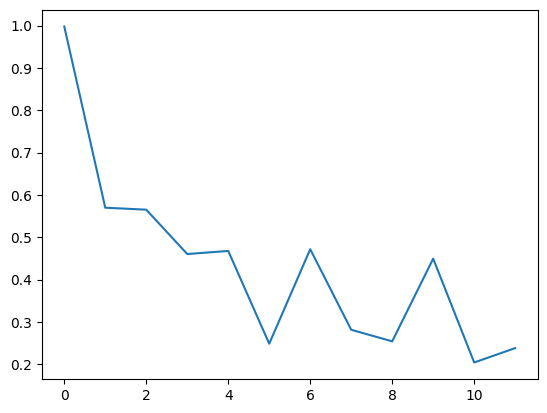

In [62]:
# Train the model
num_epochs = 2
loss_history = []
for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    latent = encoder(images)
    output = mlp(latent)
    loss = loss_fun(output, labels)
    loss.backward()
    optimizer.step()

    if (i+1) % batch_size == 0:
      loss_history.append(loss.item())
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))


plt.plot(loss_history)

In [63]:
def evaluate(encoder, classifier):
  # Run the trained model on the testing set
  correct = 0
  total = 0
  for images,labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    out = classifier(encoder(images))
    _, predicted_labels = torch.max(out,1)
    correct += (predicted_labels == labels).sum()
    total += labels.size(0)

  print('Percent correct: %.3f %%' %((100*correct)/(total+1)))


evaluate(encoder, mlp)

Percent correct: 92.521 %


## Task 5

Finally, create new instances of encoder and MLP networks and train them jointly.

Epoch [1/2], Step [100/600], Loss: 0.5650
Epoch [1/2], Step [200/600], Loss: 0.4099
Epoch [1/2], Step [300/600], Loss: 0.2476
Epoch [1/2], Step [400/600], Loss: 0.2419
Epoch [1/2], Step [500/600], Loss: 0.1500
Epoch [1/2], Step [600/600], Loss: 0.0753
Epoch [2/2], Step [100/600], Loss: 0.0907
Epoch [2/2], Step [200/600], Loss: 0.1085
Epoch [2/2], Step [300/600], Loss: 0.1657
Epoch [2/2], Step [400/600], Loss: 0.1022
Epoch [2/2], Step [500/600], Loss: 0.1412
Epoch [2/2], Step [600/600], Loss: 0.1664


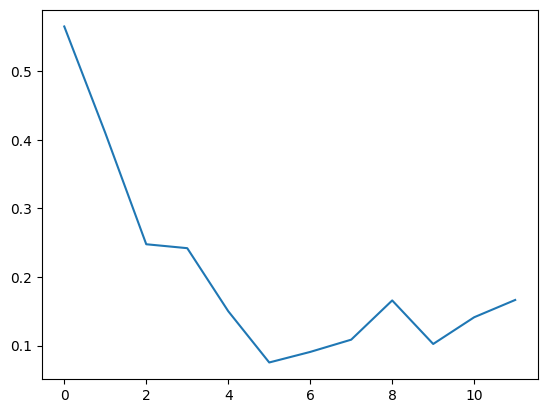

In [64]:
# Define the loss function and the optimizer
new_net1 = Encoder().to(device)
new_net2 = MLP().to(device)

loss_fun = nn.CrossEntropyLoss()
params = list(new_net1.parameters()) + list(new_net2.parameters()) # YOUR CODE HERE
optimizer = torch.optim.Adam( params, lr=1.e-3)

#@title

num_epochs = 2
loss_history = []
for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    latent = new_net1(images)
    output = new_net2(latent)
    loss = loss_fun(output, labels)
    loss.backward()
    optimizer.step()

    if (i+1) % batch_size == 0:
      loss_history.append(loss.item())
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))

plt.plot(loss_history)



In [65]:
# Run the trained model on the testing set
evaluate(new_net1, new_net2)

Percent correct: 97.080 %


## Task 6 (final task)

Compare the loss plots and test accuracies obtained in tasks 4 and 5. Before doing the experiments, which one did you expect to perform better? Why? Are the results as you expected?

YOUR ANSWER HERE:

Expectations:

Pretraining the encoder (as in Task 4) before training  MLP allows the encoder to immediately capture some features from the data. However, the success of this model in task 4 will be limited for two reasons:

1 -) The encoder was pre-trained to reconstruct images. The learned information in the latent space might focus more on capturing the essential features needed for image reconstruction. This may only sometimes align with the features that are key for classification.

2-)The model consists of two parts; training just one part will limit and slow down learning. Just like the saying, "A chain is only as strong as its weakest link." if we can't train the first part according to our needs, after some time, it will just give a piece of biased information that we can't rectify by just training the second part.

However, for task 5, we trained the encoder and MLP together. This enables end-to-end learning and allows the entire model to simultaneously adapt to the task requirements. Which is both faster and makes the latent space to keep more useful information for the classification task

Observations:

The results are consistent with the expectation that training the encoder and MLP together (Task 5) would lead to better performance. The end-to-end learning approach in Task 5 has allowed the model to find a more optimal solution for the given task, resulting in a higher test accuracy and a smoother convergence trajectory, which we can see from the loss graphs.